# Deep Learning with PyTorch

Classical machine learning relies on using statistics to determine relationships between features and labels, and can be very effective for creating predictive models. However, a massive growth in the availability of data coupled with advances in the computing technology required to process it has led to the emergence of new machine learning techniques that mimic the way the brain processes information in a structure called an artificial neural network.

PyTorch is a framework for creating machine learning models, including deep neural networks (DNNs). In this example, we'll use PyTorch to create a simple neural network that classifies penguins into species based on the length and depth of their culmen (bill), their flipper length, and their body mass.

> **Citation**: The penguins dataset used in the this exercise is a subset of data collected and made available by [Dr. Kristen
Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php)
and the [Palmer Station, Antarctica LTER](https://pal.lternet.edu/), a
member of the [Long Term Ecological Research
Network](https://lternet.edu/).

## Explore the Dataset

Before we start using PyTorch to create a model, let's load the data we need from the Palmer Islands penguins dataset, which contains observations of three different species of penguin.

> **Note**: In reality, you can solve the penguin classification problem easily using classical machine learning techniques without the need for a deep learning model; but it's a useful, easy to understand dataset with which to demonstrate the principles of neural networks in this notebook.

In [28]:
import pandas as pd

# load the training dataset (excluding rows with null values)
penguins = pd.read_csv('data/penguins.csv').dropna()
penguins.head()


,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
4,36.7,19.3,193.0,3450.0,0
5,39.3,20.6,190.0,3650.0,0


In [29]:
# explore the dataset - 1
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        342 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 16.0 KB


In [30]:
# explore the dataset - 2
penguins.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
count,342.000000,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386,0.757310
std,5.459584,1.974793,14.061714,801.954536,0.763648
min,32.100000,13.100000,172.000000,2700.000000,0.000000
25%,39.225000,15.600000,190.000000,3550.000000,0.000000
50%,44.450000,17.300000,197.000000,4050.000000,1.000000
75%,48.500000,18.700000,213.000000,4750.000000,1.000000
max,59.600000,21.500000,231.000000,6300.000000,2.000000


In [31]:
# Deep Learning models work best when features are on similar scales
# In a real solution, we'd implement some custom normalization for each feature, but to keep things simple
# we'll just rescale the FlipperLength and BodyMass so they're on a similar scale to the bill measurements
penguins['FlipperLength'] = penguins['FlipperLength']/10
penguins['BodyMass'] = penguins['BodyMass']/100
penguins.describe()


,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
count,342.000000,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,20.091520,42.017544,0.757310
std,5.459584,1.974793,1.406171,8.019545,0.763648
min,32.100000,13.100000,17.200000,27.000000,0.000000
25%,39.225000,15.600000,19.000000,35.500000,0.000000
50%,44.450000,17.300000,19.700000,40.500000,1.000000
75%,48.500000,18.700000,21.300000,47.500000,1.000000
max,59.600000,21.500000,23.100000,63.000000,2.000000


In [32]:
# The dataset is too small to be useful for deep learning
# So we'll oversample it to increase its size
for i in range(1,3):
    # penguins = penguins.append(penguins) - obsolete method
    penguins = pd.concat([penguins, penguins], ignore_index=True)

# Display a random sample of 10 observations
sample = penguins.sample(10)
sample

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
725,36.0,18.5,18.6,31.00,0
453,39.7,17.7,19.3,32.00,0
529,42.6,13.7,21.3,49.50,1
632,50.3,20.0,19.7,33.00,2
638,43.2,16.6,18.7,29.00,2
1142,37.3,20.5,19.9,37.75,0
1097,39.6,17.2,19.6,35.50,0
1081,39.0,17.5,18.6,35.50,0
1055,39.5,16.7,17.8,32.50,0
301,49.5,19.0,20.0,38.00,2


The **Species** column is the label our model will predict. Each label value represents a class of penguin species, encoded as 0, 1, or 2. The following code shows the actual species to which these class labels corrrespond.

In [33]:
penguin_classes = ['Adelie', 'Gentoo', 'Chinstrap']
print(sample.columns[0:5].values, 'SpeciesName')
for index, row in penguins.sample(10).iterrows():
    print('[',row[0], row[1], round(row[2],2),row[3], int(row[4]), ']',penguin_classes[int(row[-1])]) # row[-1] is the species column

['CulmenLength' 'CulmenDepth' 'FlipperLength' 'BodyMass' 'Species'] SpeciesName
[ 32.1 15.5 18.8 30.5 0 ] Adelie
[ 37.5 18.5 19.9 44.75 0 ] Adelie
[ 48.7 14.1 21.0 44.5 1 ] Gentoo
[ 39.6 20.7 19.1 39.0 0 ] Adelie
[ 50.6 19.4 19.3 38.0 2 ] Chinstrap
[ 38.6 17.0 18.8 29.0 0 ] Adelie
[ 47.3 13.8 21.6 47.25 1 ] Gentoo
[ 54.3 15.7 23.1 56.5 1 ] Gentoo
[ 37.0 16.5 18.5 34.0 0 ] Adelie
[ 49.5 19.0 20.0 38.0 2 ] Chinstrap


/tmp/ipykernel_6364/1560441568.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('[',row[0], row[1], round(row[2],2),row[3], int(row[4]), ']',penguin_classes[int(row[-1])]) # row[-1] is the species column


As is common in a supervised learning problem, we'll split the dataset into a set of records with which to train the model, and a smaller set with which to validate the trained model.

In [34]:
from sklearn.model_selection import train_test_split

features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
label = 'Species'
   
# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(penguins[features].values,
                                                    penguins[label].values,
                                                    test_size=0.30,
                                                    random_state=0)

print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
print("Sample of features and labels:")

# Take a look at the first 25 training features and corresponding labels
for n in range(0,24):
    print(x_train[n], y_train[n], '(' + penguin_classes[y_train[n]] + ')') # newline is not needed in this case

Training Set: 957, Test Set: 411 

Sample of features and labels:
[51.1 16.5 22.5 52.5] 1 (Gentoo)
[50.7 19.7 20.3 40.5] 2 (Chinstrap)
[49.5 16.2 22.9 58. ] 1 (Gentoo)
[39.3 20.6 19.  36.5] 0 (Adelie)
[42.5 20.7 19.7 45. ] 0 (Adelie)
[50.  15.3 22.  55.5] 1 (Gentoo)
[50.2  18.7  19.8  37.75] 2 (Chinstrap)
[50.7 19.7 20.3 40.5] 2 (Chinstrap)
[49.1  14.5  21.2  46.25] 1 (Gentoo)
[43.2 16.6 18.7 29. ] 2 (Chinstrap)
[38.8  17.6  19.1  32.75] 0 (Adelie)
[37.8 17.1 18.6 33. ] 0 (Adelie)
[45.8 14.2 21.9 47. ] 1 (Gentoo)
[43.8 13.9 20.8 43. ] 1 (Gentoo)
[36.  17.1 18.7 37. ] 0 (Adelie)
[43.3 13.4 20.9 44. ] 1 (Gentoo)
[36.  18.5 18.6 31. ] 0 (Adelie)
[41.1  19.   18.2  34.25] 0 (Adelie)
[33.1 16.1 17.8 29. ] 0 (Adelie)
[40.9 13.7 21.4 46.5] 1 (Gentoo)
[45.2 17.8 19.8 39.5] 2 (Chinstrap)
[48.4 14.6 21.3 58.5] 1 (Gentoo)
[43.6 13.9 21.7 49. ] 1 (Gentoo)
[38.5  17.9  19.   33.25] 0 (Adelie)


In [35]:
x_train.shape


(957, 4)

The *features* are the measurements for each penguin observation, and the *label* is a numeric value that indicates the species of penguin that the observation represents (Adelie, Gentoo, or Chinstrap).

## Install and import the PyTorch libraries

Since we plan to use PyTorch to create our penguin classifier, we'll need to run the following two cells to install and import the PyTorch libraries we intend to use. The specific installation of of PyTorch depends on your operating system and whether your computer has graphics processing units (GPUs) that can be used for high-performance processing via *cuda*. You can find detailed instructions at https://pytorch.org/get-started/locally/.

In [36]:
# !pip install torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
# the above line is obsolete, use the following line instead
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [37]:
import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.8.0+cu128


## Prepare the data for PyTorch

PyTorch makes use of *data loaders* to load training and validation data in batches. We've already loaded the data into numpy arrays, but we need to wrap those in PyTorch datasets (in which the data is converted to PyTorch *tensor* objects) and create loaders to read batches from those datasets.

In [38]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=20,
    shuffle=False, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


## Define a neural network

Now we're ready to define our neural network. In this case, we'll create a network that consists of 3 fully-connected layers:
* An input layer that receives an input value for each feature (in this case, the four penguin measurements) and applies a *ReLU* activation function.
* A hidden layer that receives ten inputs and applies a *ReLU* activation function.
* An output layer that generates a non-negative numeric output for each penguin species (which a loss function will translate into classification probabilities for each of the three possible penguin species).

In [39]:
# Number of hidden layer nodes
hl = 10

# Define the neural network
class PenguinNet(nn.Module):
    def __init__(self):
        super(PenguinNet, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, len(penguin_classes))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# Create a model instance from the network
model = PenguinNet()
print(model)
model.forward(train_x)

PenguinNet(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


tensor([[0.0000, 2.3878, 0.7039],
        [0.0000, 2.2376, 0.8472],
        [0.0000, 2.0566, 0.3027],
        ...,
        [0.0000, 2.1331, 0.4961],
        [0.0000, 2.1783, 0.6341],
        [0.0000, 1.9278, 0.3751]], grad_fn=<ReluBackward0>)

## Train the model

To train the model, we need to repeatedly feed the training values forward through the network, use a loss function to calculate the loss, use an optimizer to backpropagate the weight and bias value adjustments, and validate the model using the test data we withheld.

To do this, we'll create a function to train and optimize the model, and function to test the model. Then we'll call these functions iteratively over 50 epochs, logging the loss and accuracy statistics for each epoch.

In [40]:
def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()

        # backpropagate
        loss.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           
            
def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += loss_criteria(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


Epoch: 1


Training set: Average loss: 1.118814
Validation set: Average loss: 1.023595, Accuracy: 148/411 (36%)

Epoch: 2
Training set: Average loss: 1.010274
Validation set: Average loss: 0.983460, Accuracy: 163/411 (40%)

Epoch: 3
Training set: Average loss: 0.965314
Validation set: Average loss: 0.934165, Accuracy: 191/411 (46%)

Epoch: 4
Training set: Average loss: 0.911512
Validation set: Average loss: 0.867269, Accuracy: 250/411 (61%)

Epoch: 5
Training set: Average loss: 0.817720
Validation set: Average loss: 0.742112, Accuracy: 272/411 (66%)

Epoch: 6
Training set: Average loss: 0.733329
Validation set: Average loss: 0.691639, Accuracy: 302/411 (73%)

Epoch: 7
Training set: Average loss: 0.696301
Validation set: Average loss: 0.661350, Accuracy: 312/411 (76%)

Epoch: 8
Training set: Average loss: 0.671731
Validation set: Average loss: 0.640087, Accuracy: 327/411 (80%)

Epoch: 9
Training set: Average loss: 0.653092
Validation set: Average loss: 0.624311, Accuracy: 338/411 (82%)

Epoch: 10


While the training process is running, let's try to understand what's happening:

1. In each *epoch*, the full set of training data is passed forward through the network. There are four features for each observation, and four corresponding nodes in the input layer - so the features for each observation are passed as a vector of four values to that layer. However, for efficiency, the feature vectors are grouped into batches; so actually a matrix of multiple feature vectors is fed in each time.
2. The matrix of feature values is processed by a function that performs a weighted sum using initialized weights and bias values. The result of this function is then processed by the activation function for the input layer to constrain the values passed to the nodes in the next layer.
3. The weighted sum and activation functions are repeated in each layer. Note that the functions operate on vectors and matrices rather than individual scalar values. In other words, the forward pass is essentially a series of nested linear algebra functions. This is the reason data scientists prefer to use computers with graphical processing units (GPUs), since these are optimized for matrix and vector calculations.
4. In the final layer of the network, the output vectors contain a calculated value for each possible class (in this case, classes 0, 1, and 2). This vector is processed by a *loss function* that converts these values to probabilities and determines how far they are from the expected values based on the actual classes - so for example, suppose the output for a Gentoo penguin (class 1) observation is \[0.3, 0.4, 0.3\]. The correct prediction would be \[0.0, 1.0, 0.0\], so the variance between the predicted and actual values (how far away each predicted value is from what it should be) is \[0.3, 0.6, 0.3\]. This variance is aggregated for each batch and maintained as a running aggregate to calculate the overall level of error (*loss*) incurred by the training data for the epoch. 
5. At the end of each epoch, the validation data is passed through the network, and its loss and accuracy (proportion of correct predictions based on the highest probability value in the output vector) are also calculated. It's important to do this because it enables us to compare the performance of the model using data on which it was not trained, helping us determine if it will generalize well for new data or if it's *overfitted* to the training data.
6. After all the data has been passed forward through the network, the output of the loss function for the *training* data (but <u>not</u> the *validation* data) is passed to the opimizer. The precise details of how the optimizer processes the loss vary depending on the specific optimization algorithm being used; but fundamentally you can think of the entire network, from the input layer to the loss function as being one big nested (*composite*) function. The optimizer applies some differential calculus to calculate *partial derivatives* for the function with respect to each weight and bias value that was used in the network. It's possible to do this efficiently for a nested function due to something called the *chain rule*, which enables you to determine the derivative of a composite function from the derivatives of its inner function and outer functions. You don't really need to worry about the details of the math here (the optimizer does it for you), but the end result is that the partial derivatives tell us about the slope (or *gradient*) of the loss function with respect to each weight and bias value - in other words, we can determine whether to increase or decrease the weight and bias values in order to decrease the loss.
7. Having determined in which direction to adjust the weights and biases, the optimizer uses the *learning rate* to determine by how much to adjust them; and then works backwards through the network in a process called *backpropagation* to assign new values to the weights and biases in each layer.
8. Now the next epoch repeats the whole training, validation, and backpropagation process starting with the revised weights and biases from the previous epoch - which hopefully will result in a lower level of loss.
9. The process continues like this for 50 epochs.

## Review training and validation loss

After training is complete, we can examine the loss metrics we recorded while training and validating the model. We're really looking for two things:
* The loss should reduce with each epoch, showing that the model is learning the right weights and biases to predict the correct labels.
* The training loss and validation loss should follow a similar trend, showing that the model is not overfitting to the training data.

Let's plot the loss metrics and see:

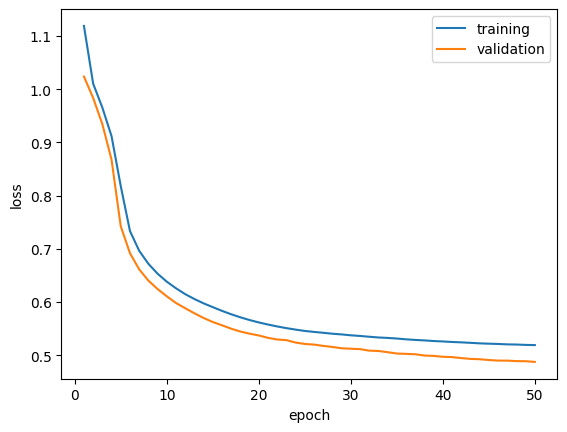

In [41]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## View the learned weights and biases

The trained model consists of the final weights and biases that were determined by the optimizer during training. Based on our network model we should expect the following values for each layer:
* Layer 1: There are four input values going to ten output nodes, so there should be 10 x 4 weights and 10 bias values.
* Layer 2: There are ten input values going to ten output nodes, so there should be 10 x 10 weights and 10 bias values.
* Layer 3: There are ten input values going to three output nodes, so there should be 3 x 10 weights and 3 bias values.

In [42]:
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

fc1.weight 
 [[-0.00374341  0.2682218  -0.41152257 -0.3679695 ]
 [-0.1791606  -0.08960593  0.11843117  0.5180272 ]
 [-0.04437202  0.13230628 -0.15110654 -0.09828269]
 [-0.47767425 -0.33114105 -0.20611155  0.01852179]
 [ 0.22086571  0.57115126 -0.40086362 -0.18697415]
 [ 0.31580445  0.24776894 -0.20200177  0.39890495]
 [-0.08059168  0.05290705  0.4527381  -0.46383518]
 [-0.3545517  -0.15797208 -0.23337851  0.39141223]
 [-0.32408983 -0.23016644 -0.34932023 -0.4682805 ]
 [-0.4734977   0.8002842   0.301804    0.15444133]]
fc1.bias 
 [ 0.02629578 -0.20744468  0.08459234 -0.46684736 -0.3558578  -0.45410094
  0.31546897  0.25728968 -0.22174752  0.24439505]
fc2.weight 
 [[ 0.20224684  0.31437248  0.12550516  0.04272011  0.21202639 -0.18619564
   0.05892716 -0.24517313 -0.21917309 -0.16335806]
 [ 0.14308454  0.08098812 -0.18731831  0.09553465  0.74755627 -0.01170831
   0.01207406  0.03671876  0.1961803   0.7177291 ]
 [-0.24369256 -0.09593002  0.12428064  0.2620103   0.44033977  0.32761896
   0.

## Evaluate model performance

So, is the model any good? The raw accuracy reported from the validation data would seem to indicate that it predicts pretty well; but it's typically useful to dig a little deeper and compare the predictions for each possible class. A common way to visualize the performance of a classification model is to create a *confusion matrix* that shows a crosstab of correct and incorrect predictions for each class.

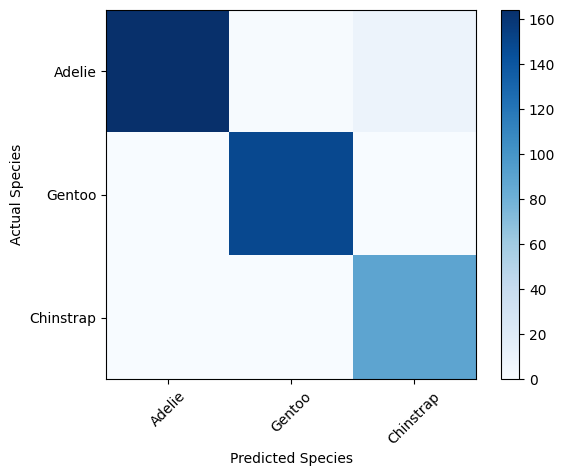

In [43]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data
x = torch.Tensor(x_test).float()
_, predicted = torch.max(model(x).data, 1)

# Plot the confusion matrix
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()

The confusion matrix should show a strong diagonal line indicating that there are more correct than incorrect predictions for each class.

## Save the trained model
Now that we have a model we believe is reasonably accurate, we can save its trained weights for use later.

In [44]:
# Save the model weights
model_file = 'models/penguin_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as models/penguin_classifier.pt


## Use the trained model

When we have a new penguin observation, we can use the model to predict the species.

In [45]:
# New penguin features
x_new = [[50.4,15.3,20,50]]
print ('New sample: {}'.format(x_new))

# Create a new model class and load weights
model = PenguinNet()
model.load_state_dict(torch.load(model_file))

# Set model to evaluation mode
model.eval()

# Get a prediction for the new data sample
x = torch.Tensor(x_new).float()
_, predicted = torch.max(model(x).data, 1)

print('Prediction:',penguin_classes[predicted.item()])

New sample: [[50.4, 15.3, 20, 50]]
Prediction: Gentoo


## Learn more

This notebook was designed to help you understand the basic concepts and principles involved in deep neural networks, using a simple PyTorch example. To learn more about PyTorch, take a look at the [tutorials on the PyTorch web site](https://pytorch.org/tutorials/).